# Tcorr Tinkering

##### ...

## FrontMatter

In [12]:
try:
    import ee
except ModuleNotFoundError:
    !pip install earthengine-api
    import ee

In [13]:
# import packages
import pprint
from IPython.display import Image

In [14]:
# Import the SSEBop package, installing it first, if needed.
try:
    import openet.ssebop as ssebop_model
except ModuleNotFoundError:
    !pip install openet-ssebop
    import openet.ssebop as ssebop_model

In [15]:
# Initialize the Earth Engine package, initiating the authentication flow if needed.
# If you have done this in anaconda prompt/ terminal when you run this notebook that will work well.

try:
#     ee.Initialize(project='gee-proof-of-concept')
    ee.Initialize()
except ee.EEException:
    ee.Authenticate()
    ee.Initialize(project='gee-proof-of-concept')

In [16]:
# visualization parameters
ndvi_palette = ['#EFE7E1', '#003300']
et_palette = [
    'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
    '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']
OrRd_palette= ['#d53e4f','#f46d43','#fdae61','#fee08b','#ffffbf','#e6f598','#abdda4','#66c2a5','#3288bd']

image_size = 768

## Overpass One: 2018

In [17]:
# ls_id_5_14 = 'LC08_037030_20200605'
ls_id_5_14 = 'LC08_022030_20200409'

#=====================================================
# Salinas - 'LC08_043035_20190715'  --
# Puget - 'LC08_047026_20200814' --
# LC08_043035_20190715 - Amarillo 
# LT05_023031_20000714 - Chicago 
# LC08_033037_20200609 - New Mexico 
# LC08_015032_20200729 - Philadelphia
# LC08_037037_20200707 - Phoenix 
# LT05_017038_20000720 - Savannah 
# LC08_033038_20180604 - El Paso
# LC08_037030_20200605 - Big Piney
# LC08_044033_20200505 - Central Valley Rice Fields
#=====================================================
# // var start_date = '2019-07-15' // Salinas scene
# // var end_date = '2019-07-16'
# // var start_date = '2019-08-28' // WA scene
# // var end_date = '2019-08-29'

# // var start_date = '2019-06-10' // New Orleans scene --tough image
# // var end_date = '2019-06-11'
# // **
# // var start_date = '2019-06-13' // Lake Tahoe scene -- see water artifacts, high ETf generally
# // var end_date = '2019-06-14'
# // **
# // var start_date = '2018-02-24' // Phoenix scene -- before and after ETf!
# // var end_date = '2018-02-25'
# //**
# // var start_date = '2019-05-05' // WA (Puget) scene -- not ideal, new ETf too high!?
# // var end_date = '2019-05-06'
# //**
# // var start_date = '2018-06-04' // El Paso, TX - great C factor impact on ETf!
# // var end_date = '2018-06-05'


tstyle = 'FANO_waterQA_debugI'

In [18]:
landsat_img = ee.Image('LANDSAT/LC08/C02/T1_L2/'+ ls_id_5_14)
# if landsat 5...
# landsat_img = ee.Image('LANDSAT/LT05/C02/T1_L2/'+ ls_id_5_14)

print('landsat quality band')
print(landsat_img.select(['QA_PIXEL']))

landsat_crs = landsat_img.select('SR_B3').projection().getInfo()['crs']
landsat_region = landsat_img.geometry().bounds(1, 'EPSG:4326')
landsat_dt = ee.Date(landsat_img.get('system:time_start'))

landsat quality band
ee.Image({
  "functionInvocationValue": {
    "functionName": "Image.select",
    "arguments": {
      "bandSelectors": {
        "constantValue": [
          "QA_PIXEL"
        ]
      },
      "input": {
        "functionInvocationValue": {
          "functionName": "Image.load",
          "arguments": {
            "id": {
              "constantValue": "LANDSAT/LC08/C02/T1_L2/LC08_022030_20200409"
            }
          }
        }
      }
    }
  }
})


##### Fun initial Visualization

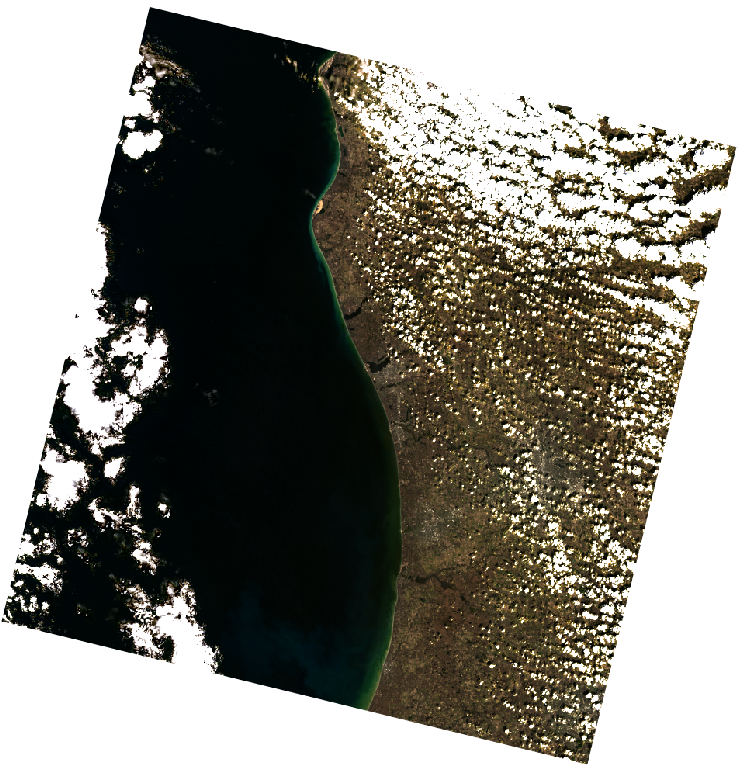

In [19]:
image_url = landsat_img.select(['SR_B4', 'SR_B3', 'SR_B2'])\
    .multiply([0.0000275, 0.0000275, 0.0000275])\
    .add([-0.2, -0.2, -0.2])\
    .getThumbURL({'min': 0.0, 'max': 0.3, 
                  'region': landsat_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

##### Nice Cloud free image. Let's look at the rest of the components of this image.

In [20]:
# Build the SSEBop object from the Landsat image
model_obj = ssebop_model.Image.from_landsat_c2_sr(
    landsat_img, 
    tcorr_source='FANO',
    et_reference_source='projects/usgs-ssebop/pet/gridmet_median_v1', 
    dt_source = 'projects/usgs-ssebop/dt/daymet_median_v6',
#     et_reference_source ='projects/usgs-ssebop/pet/ucrb_gridmet2020',
    et_reference_band='etr', 
    et_reference_factor=1,
    et_reference_resample='nearest',
#     et_reference_date_type='daily',
    et_reference_date_type='doy',
    tmax_source = 'projects/usgs-ssebop/tmax/daymet_v4_mean_1981_2010'
)

## NDVI

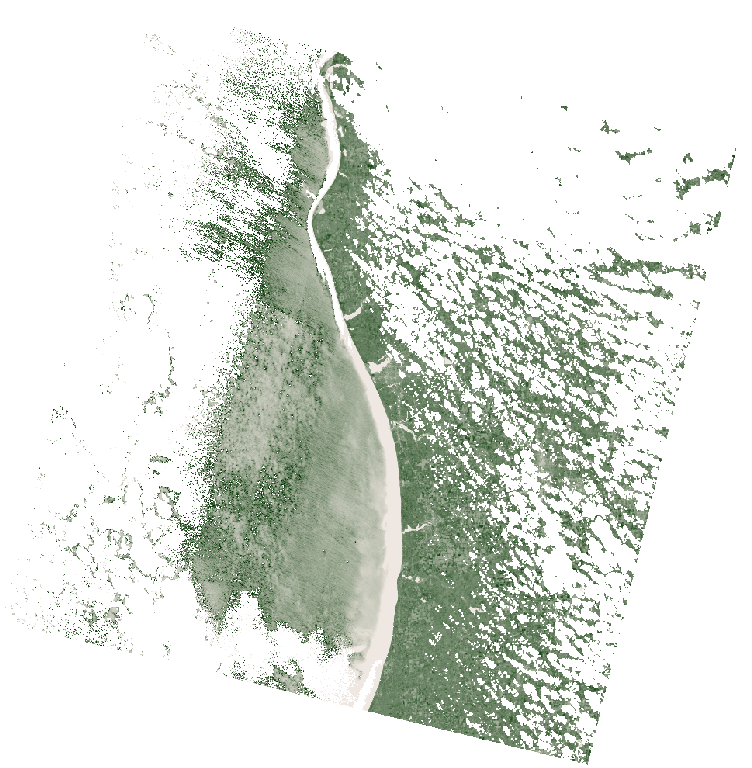

In [21]:
# save as a variable for later
ndvi = model_obj.ndvi

image_url = ndvi\
    .getThumbURL({'min': -0.1, 'max': 0.9, 'palette': ndvi_palette, 
                  'region': landsat_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')


## ET Fraction

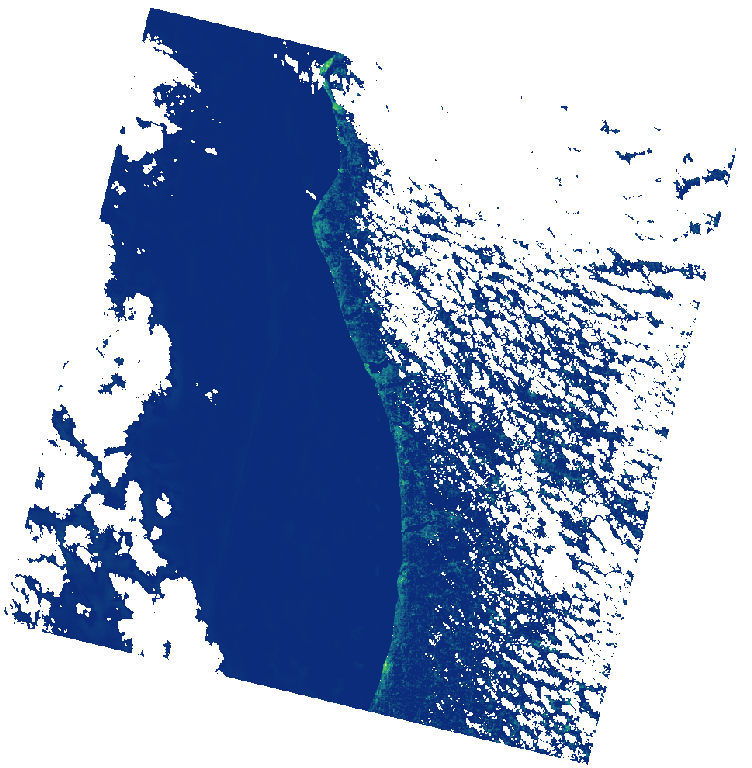

In [24]:
# save as a variable for later
etf = model_obj.et_fraction

image_url = etf\
    .getThumbURL({'min': 0.0, 'max': 1.0, 'palette': et_palette, 
                  'region': landsat_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')


## Reference ET

In [27]:
# # save as a variable for later
# etr = model_obj.et_reference

# # Clip and project to the Landsat image footprint and coordinate system
# image_url = etr\
#     .getThumbURL({'min': 0.0, 'max': 12, 'palette': et_palette, 
#                   'region': landsat_region, 'dimensions': image_size})
# Image(image_url, embed=True, format='png')



## And Finally, the model result is ETa: Actual ET ->

In [28]:
# # save as a variable for later
# et = model_obj.et

# image_url = et\
#     .getThumbURL({'min': 0.0, 'max': 12, 'palette': et_palette, 
#                   'region': landsat_region, 'dimensions': image_size})
# Image(image_url, embed=True, format='png')

##### Get tcorr (hard to visualize for some reason) in order to export it further on down

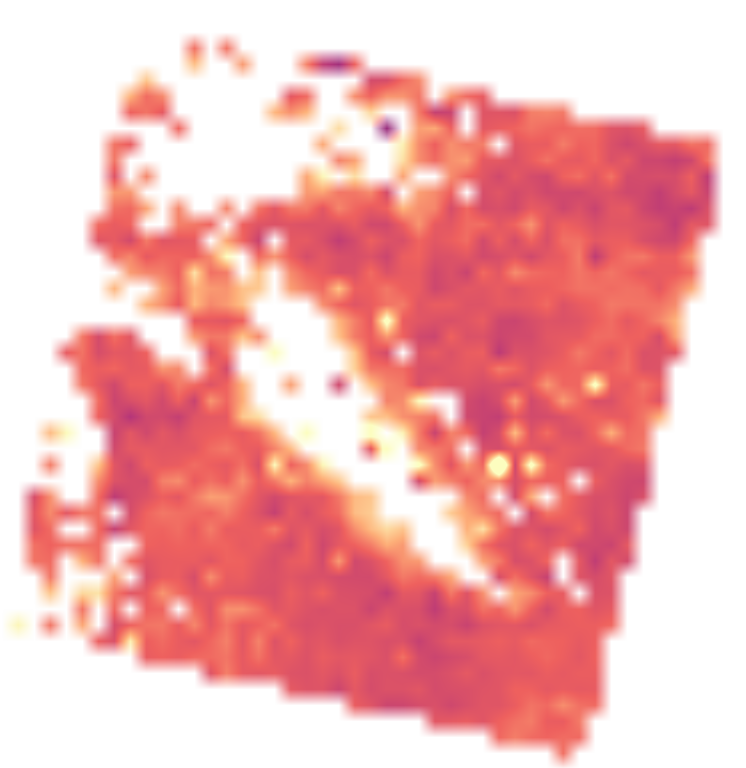

In [29]:
tcorr = model_obj.tcorr_FANO

tcorr_palette = ['FCFDBF', 'FDAE78', 'EE605E', 'B63679', '711F81', '2C105C']

image_url = tcorr\
    .getThumbURL({'min': 0.97, 'max':1.1, 'palette': tcorr_palette, 
                  'region': landsat_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

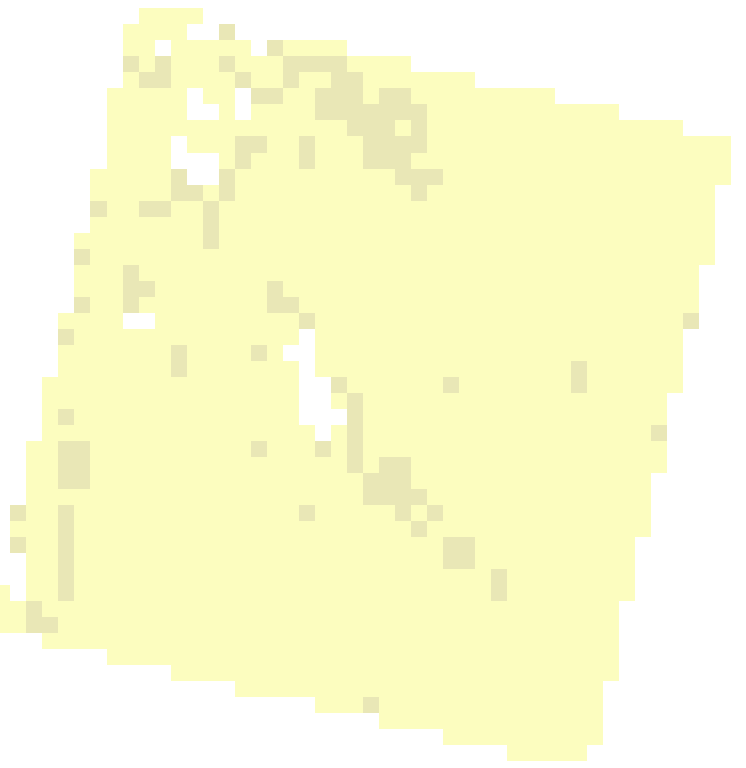

In [30]:
wrm = model_obj.wet_region_mask

binary_pall = ['FCFDBF', '2C105C']

image_url = wrm\
    .getThumbURL({'min': 0, 'max':11, 'palette':binary_pall, 
                  'region': landsat_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

## EXPORTING Results (ETa)

##### The following helps us send images to google drive:

In [31]:
def ee_task_start(task, n=10):
    """Make an exponential backoff Earth Engine request"""
    output = None
    for i in range(1, n):
        try:
            task.start()
            break
        except Exception as e:
            time.sleep(i ** 2)
    return task

## Uncomment code in the cells below to export images to your google drive, changing the paths as appropriate:

In [32]:
# ==== exporting tcorr ======
task = ee.batch.Export.image.toAsset(image=tcorr, description='tcorr'+ls_id_5_14 + tstyle, assetId='users/gbrlparrish/'+ 'tcorr_' + tstyle +ls_id_5_14, region=landsat_region)
# task = ee.batch.Export.image.toDrive(image=tcorr, description='tcorr'+ls_id_5_14+ tstyle, folder='GEE', region=landsat_region)
# start the task
print('starting')
ee_task_start(task=task)
print('task submitted')

starting
task submitted


In [33]:
# # ==== exporting ndvi ======
# task = ee.batch.Export.image.toAsset(image=ndvi, description='ndvi'+ls_id_5_14 + tstyle, assetId='users/gparrish/'+ 'ndvi'+ tstyle + ls_id_5_14, region=landsat_region)
# # task = ee.batch.Export.image.toDrive(image=ndvi, description='ndvi'+ls_id_5_14+ tstyle, folder='GEE', region=landsat_region)
# # start the task
# print('starting')
# ee_task_start(task=task)
# print('task submitted')

In [34]:
# # ==== exporting wet region mask ======
task = ee.batch.Export.image.toAsset(image=ndvi, description='wrm_'+ls_id_5_14 + tstyle, assetId='users/gparrish/'+ 'ndvi'+ tstyle + ls_id_5_14, region=landsat_region)
# task = ee.batch.Export.image.toDrive(image=ndvi, description='ndvi'+ls_id_5_14+ tstyle, folder='GEE', region=landsat_region)
# start the task
print('starting')
ee_task_start(task=task)
print('task submitted')

starting
task submitted


In [35]:
# ==== exporting ET Fraction ======
task = ee.batch.Export.image.toAsset(image=etf, description='etf'+ls_id_5_14 + tstyle, assetId='users/gbrlparrish/'+ 'etf_'+ tstyle +ls_id_5_14, region=landsat_region)
# task = ee.batch.Export.image.toDrive(image=etf, description='etf'+ls_id_5_14 + tstyle, folder='GEE', region=landsat_region)
# start the task
print('starting')
ee_task_start(task=task)
print('task submitted')

starting
task submitted


In [36]:
# # ==== exporting ETr, Reference ET ======
# task = ee.batch.Export.image.toAsset(image=etr, description='etr'+ ls_id_5_14 + tstyle, assetId='users/gparrish/'+ 'etr'+ tstyle + ls_id_5_14, region=landsat_region)
# # task = ee.batch.Export.image.toDrive(image=etr, description='etr'+ls_id_5_14 + tstyle, folder='GEE', region=landsat_region)
# # start the task
# print('starting')
# ee_task_start(task=task)
# print('task submitted')

In [37]:
# # ==== exporting ETa, Actual ET for comparison with the Lysimeter, etc. ======
# task = ee.batch.Export.image.toAsset(image=et, description='eta'+ls_id_5_14 + tstyle, assetId='users/gparrish/'+ 'et'+ tstyle + ls_id_5_14, region=landsat_region)
# # task = ee.batch.Export.image.toDrive(image=et, description='eta'+ls_id_5_14 + tstyle, folder='GEE', region=landsat_region)
# # start the task
# print('starting')
# ee_task_start(task=task)
# print('task submitted')